In [ ]:
import pandas as pd
import os

image_dir = "koniq10k_512x384"

In [ ]:
# Extract simplified features (only 6 key features)
from features import build_features, feature_names

print("Extracting simplified features:", feature_names)
df_features = build_features(image_dir, out_csv="features.csv")
print(f"Features extracted: {df_features.shape}")
print("\nFirst few rows:")
print(df_features.head())

In [ ]:
# Display feature statistics
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(feature_names):
    axes[i].hist(df_features[feature], bins=30, alpha=0.7, edgecolor="black")
    axes[i].set_title(f'{feature.replace("_", " ").title()}')
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFeature Summary Statistics:")
print(df_features[feature_names].describe())

In [ ]:
from scoring import compute_all_scores

compute_all_scores("koniq10k_512x384")

In [ ]:
# Build MOS mapping models per IQA method and prepare router training dataset
import numpy as np
from sklearn.linear_model import LinearRegression
import json

df_scores = pd.read_csv("iqa_raw_scores.csv")
df_mos = pd.read_csv("koniq10k_scores_and_distributions.csv")
df_features = pd.read_csv("features.csv")

if "image_name" not in df_scores.columns:
    df_scores.columns = ["image_name"] + list(df_scores.columns[1:])

df = df_scores.merge(df_mos[["image_name", "MOS"]], on="image_name")
df = df.merge(df_features, left_on="image_name", right_on="image_path")

iqa_methods = ["brisque", "niqe", "piqe", "maniqa", "hyperiqa"]
mos_predictions = {}
regression_coefficients = {}

for method in iqa_methods:
    reg = LinearRegression()
    X = df[[method]].values
    y = df["MOS"].values
    reg.fit(X, y)
    mos_predictions[f"{method}_mos"] = reg.predict(X)
    regression_coefficients[method] = {
        "coef": float(reg.coef_[0]),
        "intercept": float(reg.intercept_),
    }
    print(f"{method}: R²={reg.score(X, y):.4f}")

with open("mos_mapping_coefficients.json", "w") as f:
    json.dump(regression_coefficients, f, indent=2)

errors = {
    method: np.abs(mos_predictions[f"{method}_mos"] - df["MOS"].values)
    for method in iqa_methods
}
errors_df = pd.DataFrame(errors)
df["best_method"] = errors_df.idxmin(axis=1)
df["best_method_label"] = df["best_method"].map(
    {m: i for i, m in enumerate(iqa_methods)}
)
df["best_method_error"] = errors_df.min(axis=1)

print(f"\n{df['best_method'].value_counts()}")
df.to_csv("router_training_data.csv", index=False)
print(f"Dataset: {df.shape}")

In [ ]:
# Train router using simplified features
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

df = pd.read_csv("router_training_data.csv")
print(f"Training with simplified features: {feature_names}")

# Use only the 6 simplified features
X = df[feature_names].values
y = df["best_method_label"].values

print(f"Training data shape: {X.shape}")
print(f"Feature names: {feature_names}")

# Train on ALL data (no split - you'll test on separate dataset later)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

router = XGBClassifier(n_estimators=100, random_state=42)
router.fit(X_scaled, y, verbose=50)

# Training performance
y_pred = router.predict(X_scaled)
print(f"Training Accuracy: {np.mean(y_pred == y):.4f}")

# Confusion matrix on training data
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=iqa_methods,
    yticklabels=iqa_methods,
)
plt.title("Confusion Matrix (Training Data) - Simplified Features")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save router and scaler
router.save_model("router_xgb.json")
joblib.dump(scaler, "scaler.pkl")
print("\n✓ Router trained with simplified features and saved!")

# Display feature importance
feature_importance = router.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.title("Feature Importance in Router Model")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

for i, (feature, importance) in enumerate(zip(feature_names, feature_importance)):
    print(f"{i+1}. {feature.replace('_', ' ').title()}: {importance:.4f}")

Loading LIVE In-the-Wild dataset...
Original LIVE MOS range: [3.42, 92.43]
Normalized LIVE MOS range: [0.17, 4.62]
Loaded 1169 image records from .mat files
Found 1162 image files (BMP/JPG) in Images folder
Before filtering: 1169 MOS records
Available image files: 1162
After filtering: 1162 matched records

Testing on 1162 LIVE In-the-Wild images
Normalized MOS range: [0.17, 4.62]


Testing LIVE: 100%|██████████| 1162/1162 [03:04<00:00,  6.31it/s]




Successfully processed: 1162 images
Failed to process: 0 images

LIVE IN-THE-WILD CROSS-DATASET TEST (SCALE CORRECTED)
Trained on: KonIQ-10k (0-5 scale)
Tested on: LIVE In-the-Wild (1162 images, normalized to 0-5 scale)
SROCC: 0.7571
PLCC:  0.7782
RMSE:  0.6986
MAE:   0.5638
Avg Time: 158.07ms

Method Selection Distribution:
  hyperiqa: 882 (75.9%)
  maniqa: 273 (23.5%)
  brisque: 4 (0.3%)
  piqe: 2 (0.2%)
  niqe: 1 (0.1%)


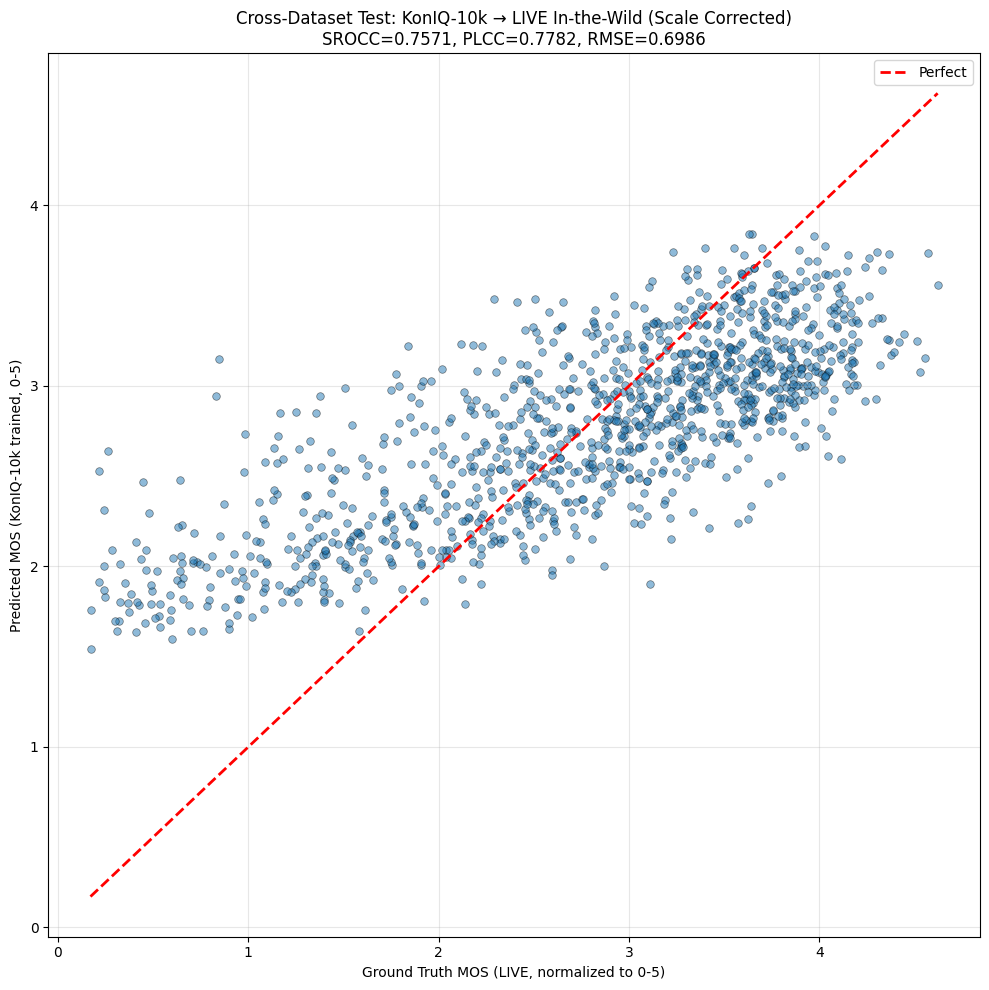


✓ Cross-dataset evaluation complete with scale correction!
Results saved to 'live_test_results_corrected.csv'
Updated plot saved as 'live_cross_dataset_results_corrected.png'


In [ ]:
# LIVE In-the-Wild testing with proper MOS scale conversion
from scipy.stats import spearmanr, pearsonr
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
from router import predict
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path

# Load LIVE In-the-Wild MOS scores from .mat files
print("Loading LIVE In-the-Wild dataset...")
mos_data = loadmat(r"LIVE In the Wild\Data\AllMOS_release.mat")
images_data = loadmat(r"LIVE In the Wild\Data\AllImages_release.mat")

# Extract image names and MOS scores
# The structure might vary, so we'll handle common formats
if 'AllMOS_release' in mos_data:
    mos_scores = mos_data['AllMOS_release'].flatten()
elif 'MOS' in mos_data:
    mos_scores = mos_data['MOS'].flatten()
else:
    # Print available keys to help debug
    print("Available keys in MOS file:", mos_data.keys())
    mos_scores = list(mos_data.values())[3].flatten()  # Skip __header__, __version__, __globals__

if 'AllImages_release' in images_data:
    image_names = [str(img[0]) for img in images_data['AllImages_release'].flatten()]
elif 'images' in images_data:
    image_names = [str(img[0]) for img in images_data['images'].flatten()]
else:
    print("Available keys in Images file:", images_data.keys())
    image_names = [str(img[0]) for img in list(images_data.values())[3].flatten()]

# IMPORTANT: Convert LIVE MOS from 0-100 scale to 0-5 scale to match our model
# LIVE: [3.42, 92.43] -> normalize to [0, 5] scale
mos_scores_normalized = (mos_scores / 100.0) * 5.0

print(f"Original LIVE MOS range: [{mos_scores.min():.2f}, {mos_scores.max():.2f}]")
print(f"Normalized LIVE MOS range: [{mos_scores_normalized.min():.2f}, {mos_scores_normalized.max():.2f}]")

# Create DataFrame with normalized MOS
live_mos_df = pd.DataFrame({
    'image_name': image_names,
    'MOS_original': mos_scores,
    'MOS': mos_scores_normalized  # Use normalized MOS for evaluation
})

print(f"Loaded {len(live_mos_df)} image records from .mat files")

# Get only images from the Images folder (not trainingImages)
live_image_dir = r"LIVE In the Wild\Images"
# Support both BMP and JPG formats as mentioned by user
available_images = [
    f.name
    for f in Path(live_image_dir).iterdir()
    if f.suffix.lower() in [".bmp", ".jpg", ".jpeg"] and f.is_file()
]

print(f"Found {len(available_images)} image files (BMP/JPG) in Images folder")

# Filter MOS data to only available images
print(f"Before filtering: {len(live_mos_df)} MOS records")
print(f"Available image files: {len(available_images)}")

live_mos_df = live_mos_df[live_mos_df["image_name"].isin(available_images)]

print(f"After filtering: {len(live_mos_df)} matched records")

# Debug matching issues
missing_in_mos = set(available_images) - set(live_mos_df["image_name"])
missing_files = set(live_mos_df["image_name"]) - set(available_images)

if missing_in_mos:
    print(f"Images without MOS data: {len(missing_in_mos)}")
    print("Sample files without MOS:", list(missing_in_mos)[:5])
    
if missing_files:
    print(f"MOS entries without files: {len(missing_files)}")
    print("Sample MOS entries without files:", list(missing_files)[:5])

print(f"\nTesting on {len(live_mos_df)} LIVE In-the-Wild images")
print(f"Normalized MOS range: [{live_mos_df['MOS'].min():.2f}, {live_mos_df['MOS'].max():.2f}]")

# Adaptive routing predictions on LIVE dataset
predictions, confidences, selected_methods, times = [], [], [], []
valid_indices = []
failed_images = []

for idx, row in tqdm(
    live_mos_df.iterrows(), total=len(live_mos_df), desc="Testing LIVE"
):
    image_path = f"{live_image_dir}/{row['image_name']}"

    try:
        result = predict(image_path)
        predictions.append(result["MOS_estimate"])
        confidences.append(result["confidence"])
        selected_methods.append(result["selected_method"])
        times.append(result["timing"]["total_time_ms"])
        valid_indices.append(idx)
    except Exception as e:
        print(f"Error on {row['image_name']}: {e}")
        failed_images.append((row['image_name'], str(e)))

print(f"\nSuccessfully processed: {len(valid_indices)} images")
print(f"Failed to process: {len(failed_images)} images")
if failed_images:
    print("Sample failures:")
    for img, error in failed_images[:5]:
        print(f"  {img}: {error}")

ground_truth = live_mos_df.loc[valid_indices, "MOS"].values

# Compute metrics
srocc = spearmanr(predictions, ground_truth)[0]
plcc = pearsonr(predictions, ground_truth)[0]
rmse = np.sqrt(mean_squared_error(ground_truth, predictions))
mae = mean_absolute_error(ground_truth, predictions)

print(f"\n{'='*60}")
print(f"LIVE IN-THE-WILD CROSS-DATASET TEST (SCALE CORRECTED)")
print(f"{'='*60}")
print(f"Trained on: KonIQ-10k (0-5 scale)")
print(f"Tested on: LIVE In-the-Wild ({len(predictions)} images, normalized to 0-5 scale)")
print(f"SROCC: {srocc:.4f}")
print(f"PLCC:  {plcc:.4f}")
print(f"RMSE:  {rmse:.4f}")
print(f"MAE:   {mae:.4f}")
print(f"Avg Time: {np.mean(times):.2f}ms")
print(f"{'='*60}")

# Method usage statistics
method_counts = Counter(selected_methods)
print(f"\nMethod Selection Distribution:")
for method, count in method_counts.most_common():
    print(f"  {method}: {count} ({count/len(selected_methods)*100:.1f}%)")

# Scatter plot with corrected scale
plt.figure(figsize=(10, 10))
plt.scatter(
    ground_truth, predictions, alpha=0.5, s=30, edgecolors="black", linewidths=0.5
)
plt.plot(
    [ground_truth.min(), ground_truth.max()],
    [ground_truth.min(), ground_truth.max()],
    "r--",
    linewidth=2,
    label="Perfect",
)
plt.xlabel("Ground Truth MOS (LIVE, normalized to 0-5)")
plt.ylabel("Predicted MOS (KonIQ-10k trained, 0-5)")
plt.title(
    f"Cross-Dataset Test: KonIQ-10k → LIVE In-the-Wild (Scale Corrected)\n"
    f"SROCC={srocc:.4f}, PLCC={plcc:.4f}, RMSE={rmse:.4f}"
)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save detailed results with both original and normalized MOS
pd.DataFrame(
    {
        "image_name": live_mos_df.loc[valid_indices, "image_name"].values,
        "ground_truth_original_0_100": live_mos_df.loc[valid_indices, "MOS_original"].values,
        "ground_truth_normalized_0_5": ground_truth,
        "predicted_0_5": predictions,
        "method": selected_methods,
        "confidence": confidences,
        "time_ms": times,
        "error": np.abs(predictions - ground_truth),
    }
).to_csv("live_test_results_corrected.csv", index=False)

print("\n✓ Cross-dataset evaluation complete with scale correction!")
print("Results saved to 'live_test_results_corrected.csv'")
print("Updated plot saved as 'live_cross_dataset_results_corrected.png'")

In [16]:
def assess_image(image_path):
    """
    Quick image quality assessment using simplified features and adaptive routing.
    Uses only 6 key features: brightness, contrast, colorfulness, sharpness, saturation, texture/noise.
    """
    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")

    result = predict(image_path)

    print(f"Image: {os.path.basename(image_path)}")
    print(f"MOS: {result['MOS_estimate']:.3f}/5.0")
    print(
        f"Method: {result['selected_method']} (confidence: {result['confidence']:.3f})"
    )
    print(f"Time: {result['timing']['total_time_ms']:.2f}ms")

    # Show the extracted features for this image
    from features import extract_features

    features = extract_features(image_path)
    print(f"\nExtracted Features:")
    for i, (name, value) in enumerate(zip(feature_names, features)):
        print(f"  {i+1}. {name.replace('_', ' ').title()}: {value:.4f}")

    return result


# Example usage with the simplified feature set
print("=== Simplified NR-IQA Assessment ===")
print(f"Using {len(feature_names)} simplified features: {', '.join(feature_names)}")
print()
r = assess_image("me at night.jpg")

=== Simplified NR-IQA Assessment ===
Using 6 simplified features: brightness, contrast, colorfulness, sharpness, saturation, texture_noise

Image: me at night.jpg
MOS: 2.227/5.0
Method: hyperiqa (confidence: 0.494)
Time: 253.91ms

Extracted Features:
  1. Brightness: 0.4667
  2. Contrast: 0.2300
  3. Colorfulness: 0.1075
  4. Sharpness: 432.3902
  5. Saturation: 0.1890
  6. Texture Noise: 0.0045
Image: me at night.jpg
MOS: 2.227/5.0
Method: hyperiqa (confidence: 0.494)
Time: 253.91ms

Extracted Features:
  1. Brightness: 0.4667
  2. Contrast: 0.2300
  3. Colorfulness: 0.1075
  4. Sharpness: 432.3902
  5. Saturation: 0.1890
  6. Texture Noise: 0.0045
